NIDS ON KDDCUUP - VAE

In [ ]:
# Downloading the KDD99 dataset
!wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz
!wget http://kdd.ics.uci.edu/databases/kddcup99/corrected.gz
!wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
# unzipping the files
!gzip -d /content/kddcup.data.gz
!gzip -d /content/corrected.gz


--2025-03-01 01:58:36--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18115902 (17M) [application/x-gzip]
Saving to: ‘kddcup.data.gz’

kddcup.data.gz      100%[===================>]  17.28M  2.22MB/s    in 15s     

2025-03-01 01:58:51 (1.17 MB/s) - ‘kddcup.data.gz’ saved [18115902/18115902]

--2025-03-01 01:58:51--  http://kdd.ics.uci.edu/databases/kddcup99/corrected.gz
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1409035 (1.3M) [application/x-gzip]
Saving to: ‘corrected.gz’

corrected.gz        100%[===================>]   1.34M  1.03MB/s    in 1.3s    

2025-03-01 01:58:53 (1.03 MB/s) - ‘corrected.gz’ saved [1409035/1409035]

--2025-0

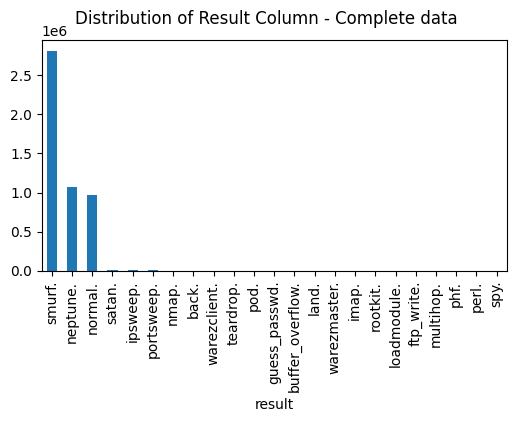

In [ ]:
import pandas as pd

# reading the training data file
df = pd.read_csv("/content/kddcup.data", header=None)

# reading the file containing feature names
with open("/content/kddcup.names", 'r') as txt_file:
    col_names = txt_file.readlines()
col_names_cleaned = [i.split(':')[0] for i in col_names[1:]]


# adding an extra column for the indicator
col_names_cleaned.extend(['result'])
df.columns = col_names_cleaned

# Plot the distribution of the result column in the complete dataset
import matplotlib.pyplot as plt
df['result'].value_counts().plot(kind='bar', figsize=(6, 3))
plt.suptitle('Distribution of Result Column - Complete data')
plt.show()

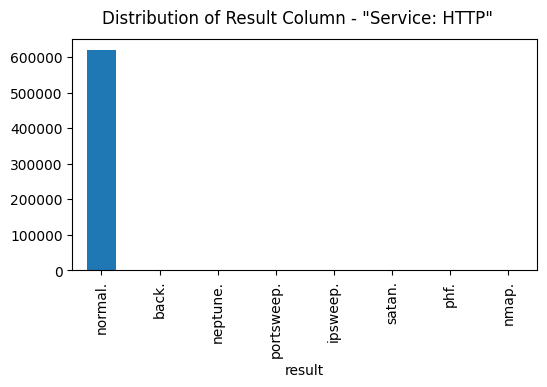

In [ ]:

# Filter the dataframe for HTTP service
df_http = df[df.service == 'http']
df_http['result'].value_counts().plot(kind='bar', figsize=(6, 3))
plt.suptitle('Distribution of Result Column - "Service: HTTP"')
plt.show()


In [ ]:
df.result.value_counts()

,count
result,
smurf.,2807886
neptune.,1072017
normal.,972781
satan.,15892
ipsweep.,12481
portsweep.,10413
nmap.,2316
back.,2203
warezclient.,1020


In [ ]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch

# Filter for normal HTTP traffic
df_http_normal = df_http[df_http.result == "normal."]
# Drop categorical columns
df_http_normal.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'result'], axis=1, inplace=True)
# Drop columns with no standard deviation
df_http_normal.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted', 'num_file_creations', 'num_outbound_cmds'], axis=1, inplace=True)

# Step 1: Transform data to zero mean, std dev as one
scaler = StandardScaler()
X = df_http_normal.to_numpy()
X_scaled = scaler.fit_transform(X)

# Step 2: Convert the NumPy array to a PyTorch tensor
X_scaled = torch.tensor(X_scaled, dtype=torch.float32)

<ipython-input-5-74d4dc500c26>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_http_normal.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'result'], axis=1, inplace=True)
<ipython-input-5-74d4dc500c26>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_http_normal.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted', 'num_file_creations', 'num_outbound_cmds'], axis=1, inplace=True)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898431 entries, 0 to 4898430
Data columns (total 42 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   duration                     int64  
 1   protocol_type                object 
 2   service                      object 
 3   flag                         object 
 4   src_bytes                    int64  
 5   dst_bytes                    int64  
 6   land                         int64  
 7   wrong_fragment               int64  
 8   urgent                       int64  
 9   hot                          int64  
 10  num_failed_logins            int64  
 11  logged_in                    int64  
 12  num_compromised              int64  
 13  root_shell                   int64  
 14  su_attempted                 int64  
 15  num_root                     int64  
 16  num_file_creations           int64  
 17  num_shells                   int64  
 18  num_access_files             int64  
 19  

In [ ]:
# Step 3: Create a TensorDataset
dataset = TensorDataset(X_scaled, X_scaled)  # For autoencoder, input and target are the same

# Step 4: Create a DataLoader
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

import torch.nn as nn
import torch.optim as optim

# Define the VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28, 14),
            nn.ReLU(),
            nn.Linear(14, 7)
        )
        self.mu_layer = nn.Linear(7, 2)  # Mean layer
        self.logvar_layer = nn.Linear(7, 2)  # Log-variance layer
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 7),
            nn.ReLU(),
            nn.Linear(7, 14),
            nn.ReLU(),
            nn.Linear(14, 28)
        )
    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        return self.decoder(z)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize the model, loss function, and optimizer
model_vae = VAE()
model_vae.to(device)
optimizer = optim.Adam(model_vae.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    for index, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        recon, mu, logvar = model_vae(inputs)
        loss = loss_function(recon, inputs, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if index % 1000 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Iteration {index}, Loss: {loss.item():.4f}')
print("Training complete!")

# Load the test dataframe
test_df = pd.read_csv("/content/corrected", header=None, names=col_names_cleaned)
test_df_http = test_df[test_df.service == "http"]
test_df_http["target"] = test_df_http["result"].apply(lambda x: 0 if x == "normal." else 1)
target = test_df_http["target"].to_numpy()

# Drop categorical and low variance columns
test_df_http.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'result', 'target'], axis=1, inplace=True)
test_df_http.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted', 'num_file_creations', 'num_outbound_cmds'], axis=1, inplace=True)

X_test = test_df_http.to_numpy()
X_scaled_test = scaler.transform(X_test)
X_scaled_test = torch.tensor(X_scaled_test, dtype=torch.float32)

from sklearn.metrics import precision_score, recall_score
import numpy as np

with torch.no_grad():
    X_scaled_test_recon, _, _ = model_vae(X_scaled_test.to(device))
loss_test = torch.nn.functional.mse_loss(X_scaled_test_recon.to(device), X_scaled_test.to(device), reduction='none').sum(1).cpu().numpy()

# Normalize reconstruction loss to range [0, 1]
loss_test = (loss_test - loss_test.min()) / (loss_test.max() - loss_test.min())


Epoch [1/5], Iteration 0, Loss: 12.4384
Epoch [1/5], Iteration 1000, Loss: 0.6263
Epoch [1/5], Iteration 2000, Loss: 1.6049
Epoch [1/5], Iteration 3000, Loss: 0.4126
Epoch [1/5], Iteration 4000, Loss: 12.4735
Epoch [2/5], Iteration 0, Loss: 0.6436
Epoch [2/5], Iteration 1000, Loss: 0.6181
Epoch [2/5], Iteration 2000, Loss: 0.6895
Epoch [2/5], Iteration 3000, Loss: 0.5674
Epoch [2/5], Iteration 4000, Loss: 0.5279
Epoch [3/5], Iteration 0, Loss: 0.5249
Epoch [3/5], Iteration 1000, Loss: 0.5450
Epoch [3/5], Iteration 2000, Loss: 0.6520
Epoch [3/5], Iteration 3000, Loss: 0.6118
Epoch [3/5], Iteration 4000, Loss: 0.6890
Epoch [4/5], Iteration 0, Loss: 0.5371
Epoch [4/5], Iteration 1000, Loss: 0.5158
Epoch [4/5], Iteration 2000, Loss: 0.7035
Epoch [4/5], Iteration 3000, Loss: 0.4475
Epoch [4/5], Iteration 4000, Loss: 0.4540
Epoch [5/5], Iteration 0, Loss: 0.7217
Epoch [5/5], Iteration 1000, Loss: 1.2267
Epoch [5/5], Iteration 2000, Loss: 1.8417
Epoch [5/5], Iteration 3000, Loss: 0.5773
Epoch

<ipython-input-7-9ac1537513ea>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_http["target"] = test_df_http["result"].apply(lambda x: 0 if x == "normal." else 1)
<ipython-input-7-9ac1537513ea>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_http.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'result', 'target'], axis=1, inplace=True)
<ipython-input-7-9ac1537513ea>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

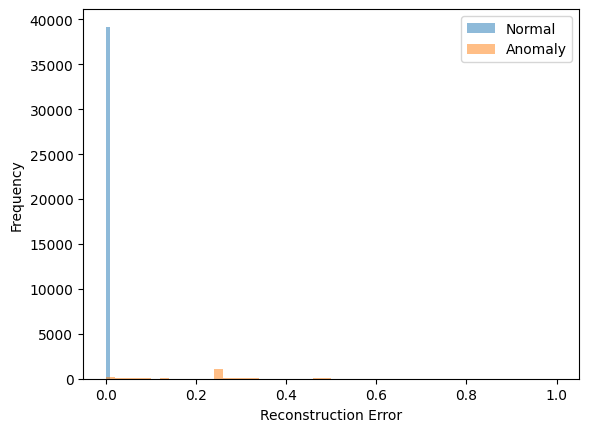

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of reconstruction errors
plt.hist(loss_test[target == 0], bins=50, alpha=0.5, label='Normal')
plt.hist(loss_test[target == 1], bins=50, alpha=0.5, label='Anomaly')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Using device: cuda
Train data shape: (4898431, 42)
Test data shape: (311029, 42)


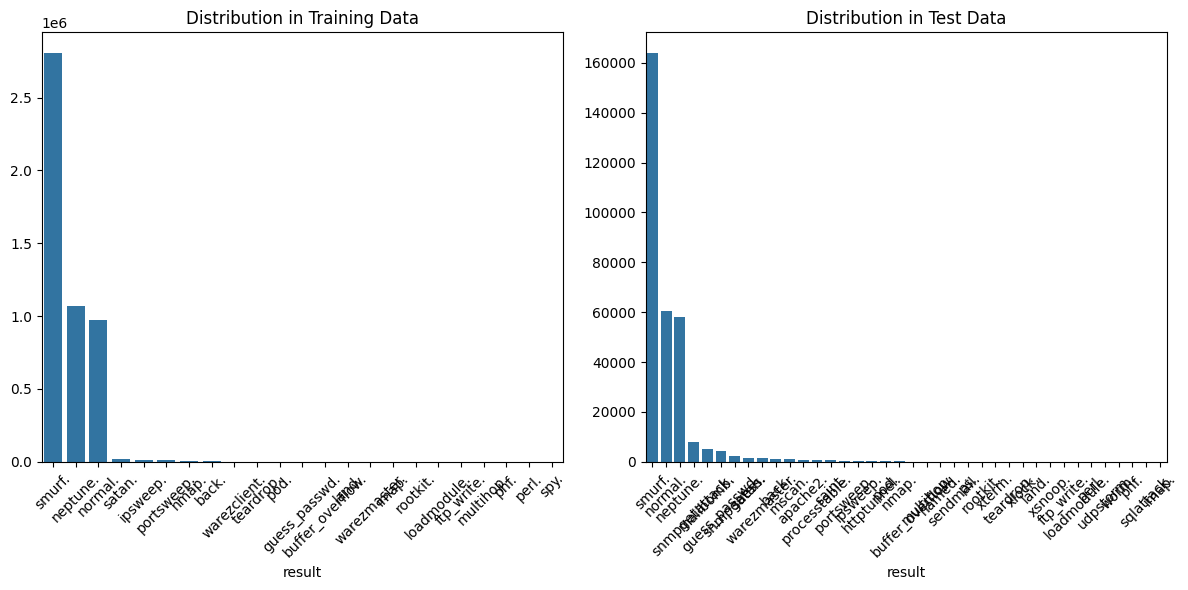

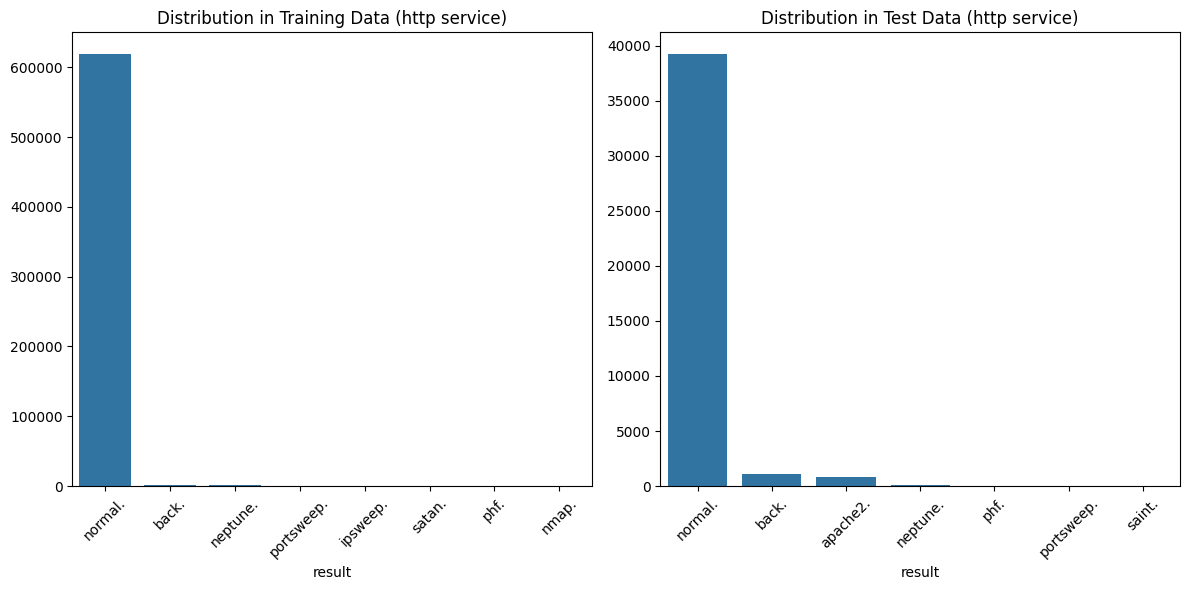

Training on 619046 normal samples
Test data distribution: {0: 39247, 1: 1990}
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=28, out_features=28, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=28, out_features=14, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=14, out_features=7, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
  )
  (mu_layer): Linear(in_features=7, out_features=3, bias=True)
  (logvar_layer): Linear(in_features=7, out_features=3, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=7, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=7, out_features=14, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=14, out_features=28, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=28, out_features=28

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [1/20], Loss: 36317.2154, Recon Loss: 181.1249, KL Loss: 36136.0912


Epoch 2/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [2/20], Loss: 23.0741, Recon Loss: 22.4719, KL Loss: 0.6022


Epoch 3/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [3/20], Loss: 22.7959, Recon Loss: 22.1839, KL Loss: 0.6120


Epoch 4/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [4/20], Loss: 22.4083, Recon Loss: 21.7504, KL Loss: 0.6578


Epoch 5/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [5/20], Loss: 22.0988, Recon Loss: 21.4105, KL Loss: 0.6884


Epoch 6/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [6/20], Loss: 21.8709, Recon Loss: 21.1640, KL Loss: 0.7069


Epoch 7/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [7/20], Loss: 21.8233, Recon Loss: 21.1075, KL Loss: 0.7158


Epoch 8/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [8/20], Loss: 21.8452, Recon Loss: 21.1248, KL Loss: 0.7204


Epoch 9/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [9/20], Loss: 21.7995, Recon Loss: 21.0564, KL Loss: 0.7430


Epoch 10/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [10/20], Loss: 21.6965, Recon Loss: 20.9737, KL Loss: 0.7228


Epoch 11/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [11/20], Loss: 21.7999, Recon Loss: 21.0811, KL Loss: 0.7188


Epoch 12/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [12/20], Loss: 21.7757, Recon Loss: 21.0545, KL Loss: 0.7212


Epoch 13/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [13/20], Loss: 21.7703, Recon Loss: 21.0507, KL Loss: 0.7197
Early stopping triggered after 13 epochs.


<ipython-input-13-1541131c39ef>:377: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vae_model.pth'))


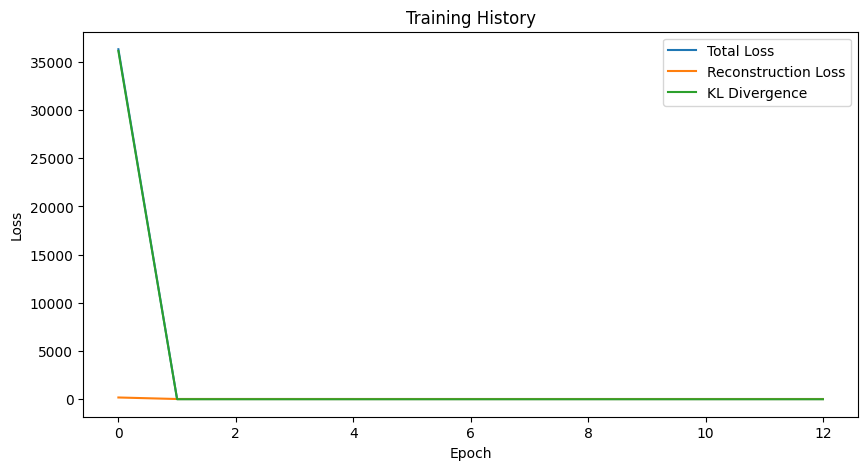

Optimal threshold: 3391.089111 with F1: 0.9593


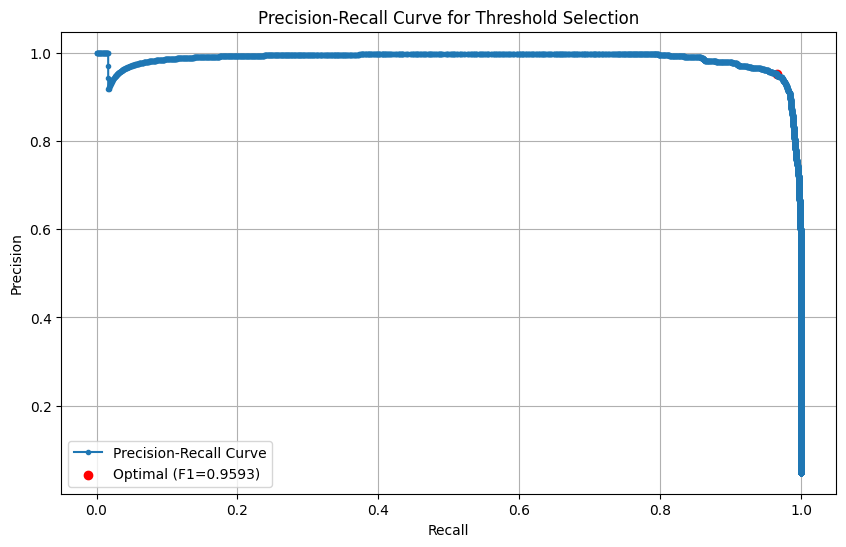

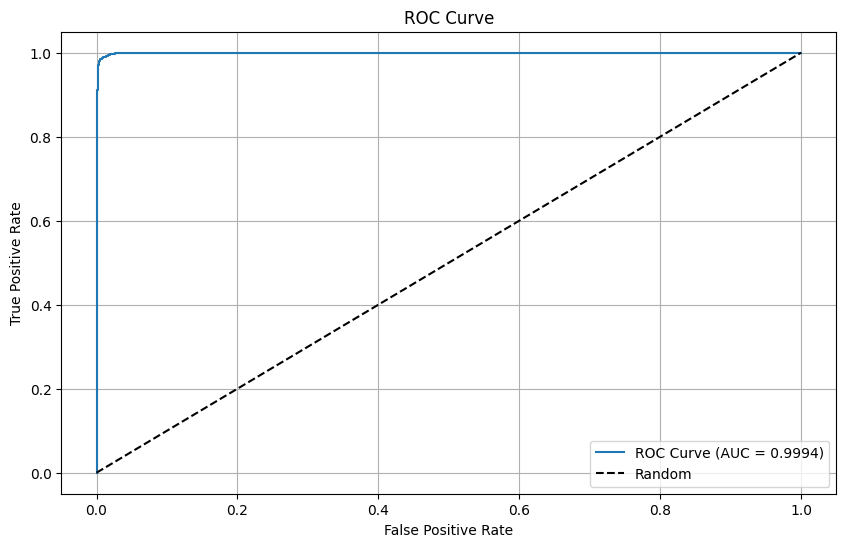


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39247
           1       0.95      0.97      0.96      1990

    accuracy                           1.00     41237
   macro avg       0.98      0.98      0.98     41237
weighted avg       1.00      1.00      1.00     41237



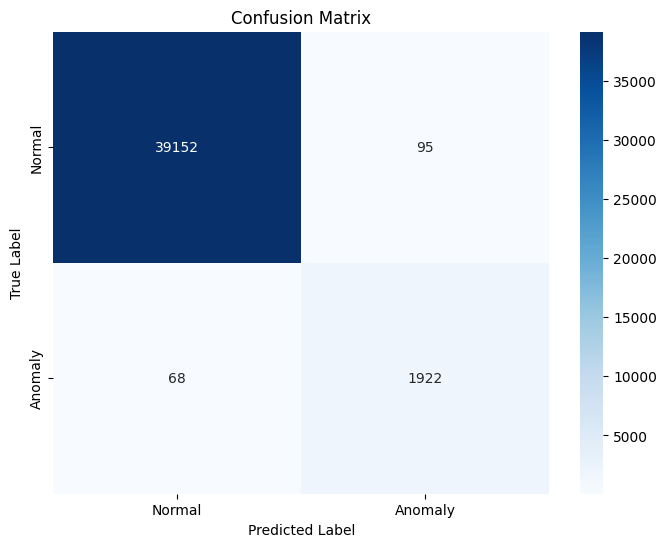


Summary Metrics:
Total samples: 41237
Total actual anomalies: 1990
Total predicted anomalies: 2017
Correctly identified anomalies: 1922
Missed anomalies: 68
False alarms: 95
Precision: 0.9529
Recall: 0.9658
F1 Score: 0.9593


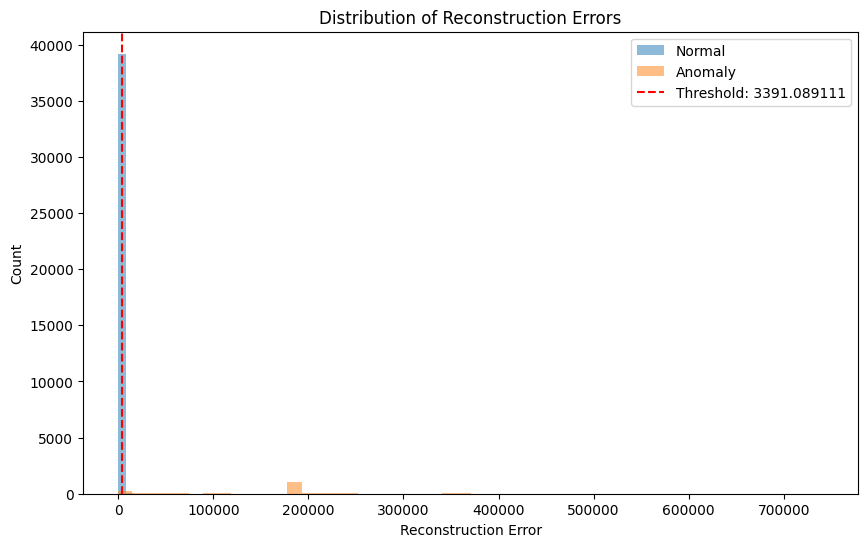

Latent space visualization skipped (dimension > 2)
Network intrusion detection analysis complete!


In [ ]:
"""
Network Intrusion Detection using Variational Autoencoder (VAE)
Based on KDD Cup 1999 dataset
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_curve, auc,
    confusion_matrix, precision_recall_curve, classification_report
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm.auto import tqdm


class Config:
    """Configuration parameters for the project."""

    # Data parameters
    # Using direct paths since files are already downloaded
    TRAIN_DATA_PATH = "/content/kddcup.data"
    TEST_DATA_PATH = "/content/corrected"
    NAMES_PATH = "/content/kddcup.names"

    RANDOM_SEED = 42
    SERVICE_TYPE = "http"  # Focus on HTTP traffic

    # Model parameters
    BATCH_SIZE = 128
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-5
    NUM_EPOCHS = 20
    EARLY_STOPPING_PATIENCE = 3
    HIDDEN_DIM = [28, 14, 7]  # Dimensions of hidden layers
    LATENT_DIM = 3  # Latent space dimension

    # Device configuration
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# This function is commented out since you've already downloaded the dataset

# def download_dataset(config):
#     # Download the KDD Cup 1999 dataset.
#     os.makedirs(config.DATA_DIR, exist_ok=True)

#     # Download each file
#     for file in config.DATA_FILES:
#         local_path = os.path.join(config.DATA_DIR, file)
#         if not os.path.exists(local_path):
#             url = config.DATASET_URL + file
#             print(f"Downloading {url}...")

#             # Using os.system instead of wget directly for better compatibility
#             os.system(f"wget {url} -O {local_path}")

#     # Unzip gzipped files
#     for file in config.DATA_FILES:
#         if file.endswith(".gz"):
#             local_path = os.path.join(config.DATA_DIR, file)
#             if os.path.exists(local_path):
#                 os.system(f"gzip -d {local_path} -f")

#     print("Download and extraction complete.")


def load_and_preprocess_data(config):
    """Load and preprocess the KDD99 dataset."""
    # Read column names
    with open(config.NAMES_PATH, 'r') as txt_file:
        col_names = txt_file.readlines()

    # Clean column names
    col_names_cleaned = [i.split(':')[0] for i in col_names[1:]]
    col_names_cleaned.append('result')

    # Read training data
    df_train = pd.read_csv(config.TRAIN_DATA_PATH, header=None, names=col_names_cleaned)

    # Read test data
    df_test = pd.read_csv(config.TEST_DATA_PATH, header=None, names=col_names_cleaned)

    print(f"Train data shape: {df_train.shape}")
    print(f"Test data shape: {df_test.shape}")

    return df_train, df_test, col_names_cleaned


def explore_data(df_train, df_test, service_type=None):
    """Explore and visualize the dataset."""
    plt.figure(figsize=(12, 6))

    # Plot distribution of full dataset
    plt.subplot(1, 2, 1)
    train_counts = df_train['result'].value_counts()
    sns.barplot(x=train_counts.index, y=train_counts.values)
    plt.title('Distribution in Training Data')
    plt.xticks(rotation=45)

    # Plot distribution of test dataset
    plt.subplot(1, 2, 2)
    test_counts = df_test['result'].value_counts()
    sns.barplot(x=test_counts.index, y=test_counts.values)
    plt.title('Distribution in Test Data')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # If service type is specified, filter and show those distributions
    if service_type:
        plt.figure(figsize=(12, 6))

        # Filter by service type
        df_train_service = df_train[df_train.service == service_type]
        df_test_service = df_test[df_test.service == service_type]

        # Plot distribution of service in training data
        plt.subplot(1, 2, 1)
        train_service_counts = df_train_service['result'].value_counts()
        sns.barplot(x=train_service_counts.index, y=train_service_counts.values)
        plt.title(f'Distribution in Training Data ({service_type} service)')
        plt.xticks(rotation=45)

        # Plot distribution of service in test data
        plt.subplot(1, 2, 2)
        test_service_counts = df_test_service['result'].value_counts()
        sns.barplot(x=test_service_counts.index, y=test_service_counts.values)
        plt.title(f'Distribution in Test Data ({service_type} service)')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        return df_train_service, df_test_service

    return df_train, df_test


def prepare_data_for_model(df_train, df_test, config):
    """Prepare data for the VAE model."""
    # Filter normal samples for training (we only train on normal data)
    df_train_normal = df_train[df_train.result == "normal."].copy()
    print(f"Training on {len(df_train_normal)} normal samples")

    # Create a copy of the test data to avoid SettingWithCopyWarning
    df_test = df_test.copy()

    # Add target column to test data (1 for anomaly, 0 for normal)
    df_test.loc[:, "target"] = df_test["result"].apply(lambda x: 1 if x != "normal." else 0)
    print(f"Test data distribution: {df_test['target'].value_counts().to_dict()}")

    # Store target values before dropping
    y_test = df_test["target"].values

    # Identify categorical and continuous columns
    categorical_cols = ['protocol_type', 'service', 'flag']
    bool_cols = ['land', 'logged_in', 'is_host_login', 'is_guest_login']

    # Define columns to drop - note that 'target' is only in the test data, not train data
    train_drop_cols = ['result', 'wrong_fragment', 'urgent', 'num_failed_logins',
                       'su_attempted', 'num_file_creations', 'num_outbound_cmds']
    test_drop_cols = train_drop_cols + ['target']  # Include 'target' for test data

    # Drop unnecessary columns from train and test data
    X_train = df_train_normal.drop(categorical_cols + bool_cols + train_drop_cols, axis=1).values
    X_test = df_test.drop(categorical_cols + bool_cols + test_drop_cols, axis=1).values

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    X_test_tensor = torch.FloatTensor(X_test_scaled)

    # Create dataset and dataloader for training
    train_dataset = TensorDataset(X_train_tensor, X_train_tensor)  # input = target for autoencoder
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        drop_last=False
    )

    return train_loader, X_train_tensor, X_test_tensor, y_test, X_train.shape[1]

class VAE(nn.Module):
    """Variational Autoencoder for Anomaly Detection."""

    def __init__(self, input_dim, hidden_dims, latent_dim, dropout_rate=0.2):
        """
        Initialize the VAE.

        Args:
            input_dim: Dimension of input features
            hidden_dims: List of hidden dimensions for encoder
            latent_dim: Dimension of latent space
            dropout_rate: Dropout rate for regularization
        """
        super(VAE, self).__init__()

        # Encoder layers
        encoder_layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, hidden_dim))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim

        self.encoder = nn.Sequential(*encoder_layers)

        # Latent space parameters
        self.mu_layer = nn.Linear(hidden_dims[-1], latent_dim)
        self.logvar_layer = nn.Linear(hidden_dims[-1], latent_dim)

        # Decoder layers
        decoder_layers = []
        prev_dim = latent_dim

        for hidden_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(prev_dim, hidden_dim))
            decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim

        decoder_layers.append(nn.Linear(hidden_dims[0], input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        """Encode input to latent space parameters."""
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization trick."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """Decode from latent space to reconstruction."""
        return self.decoder(z)

    def forward(self, x):
        """Forward pass through the VAE."""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE loss function.

    Args:
        recon_x: Reconstructed input
        x: Original input
        mu: Mean of latent distribution
        logvar: Log variance of latent distribution
        beta: Weight of KL divergence term
    """
    # Reconstruction loss (MSE)
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum') / x.size(0)

    # KL-Divergence
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    return MSE + beta * KLD, MSE, KLD


def train_model(model, train_loader, config):
    """Train the VAE model."""
    optimizer = optim.Adam(
        model.parameters(),
        lr=config.LEARNING_RATE,
        weight_decay=config.WEIGHT_DECAY
    )

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )

    # Training history
    history = {
        'total_loss': [],
        'recon_loss': [],
        'kl_loss': []
    }

    # Early stopping parameters
    best_loss = float('inf')
    early_stopping_counter = 0

    # Training loop
    for epoch in range(config.NUM_EPOCHS):
        model.train()
        epoch_loss = 0
        epoch_recon_loss = 0
        epoch_kl_loss = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.NUM_EPOCHS}")

        for inputs, _ in progress_bar:
            inputs = inputs.to(config.DEVICE)

            # Forward pass
            recon, mu, logvar = model(inputs)
            loss, recon_loss, kl_loss = vae_loss_function(recon, inputs, mu, logvar)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update metrics
            epoch_loss += loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()

            # Update progress bar
            progress_bar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'recon_loss': f"{recon_loss.item():.4f}",
                'kl_loss': f"{kl_loss.item():.4f}"
            })

        # Calculate average epoch loss
        avg_loss = epoch_loss / len(train_loader)
        avg_recon_loss = epoch_recon_loss / len(train_loader)
        avg_kl_loss = epoch_kl_loss / len(train_loader)

        # Update history
        history['total_loss'].append(avg_loss)
        history['recon_loss'].append(avg_recon_loss)
        history['kl_loss'].append(avg_kl_loss)

        # Print progress
        print(f"Epoch [{epoch+1}/{config.NUM_EPOCHS}], "
              f"Loss: {avg_loss:.4f}, "
              f"Recon Loss: {avg_recon_loss:.4f}, "
              f"KL Loss: {avg_kl_loss:.4f}")

        # Learning rate scheduler step
        scheduler.step(avg_loss)

        # Early stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            early_stopping_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_vae_model.pth')
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= config.EARLY_STOPPING_PATIENCE:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    # Load best model
    model.load_state_dict(torch.load('best_vae_model.pth'))

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history['total_loss'], label='Total Loss')
    plt.plot(history['recon_loss'], label='Reconstruction Loss')
    plt.plot(history['kl_loss'], label='KL Divergence')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model, history


def compute_reconstruction_errors(model, data_tensor, config):
    """Compute reconstruction errors for given data."""
    model.eval()
    data_tensor = data_tensor.to(config.DEVICE)

    with torch.no_grad():
        recon, _, _ = model(data_tensor)

    # Calculate MSE for each sample
    errors = torch.nn.functional.mse_loss(
        recon, data_tensor, reduction='none'
    ).sum(dim=1).cpu().numpy()

    return errors


def find_optimal_threshold(recon_errors, y_true):
    """Find the optimal threshold for anomaly detection."""
    precisions, recalls, thresholds = precision_recall_curve(y_true, recon_errors)

    # Calculate F1 score for each threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

    # Find the threshold that gives the best F1 score
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else thresholds[-1]

    print(f"Optimal threshold: {optimal_threshold:.6f} with F1: {f1_scores[optimal_idx]:.4f}")

    # Plot precision-recall curve
    plt.figure(figsize=(10, 6))
    plt.plot(recalls, precisions, marker='.', label='Precision-Recall Curve')
    plt.scatter(recalls[optimal_idx], precisions[optimal_idx], c='red', marker='o',
                label=f'Optimal (F1={f1_scores[optimal_idx]:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Threshold Selection')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_true, recon_errors)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return optimal_threshold


def evaluate_model(recon_errors, y_true, threshold):
    """Evaluate model performance based on reconstruction errors and threshold."""
    # Make predictions using the threshold
    y_pred = (recon_errors >= threshold).astype(int)

    # Calculate metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Display summary metrics
    print(f"\nSummary Metrics:")
    print(f"Total samples: {len(y_true)}")
    print(f"Total actual anomalies: {sum(y_true)}")
    print(f"Total predicted anomalies: {sum(y_pred)}")
    print(f"Correctly identified anomalies: {np.sum((y_pred == 1) & (y_true == 1))}")
    print(f"Missed anomalies: {np.sum((y_pred == 0) & (y_true == 1))}")
    print(f"False alarms: {np.sum((y_pred == 1) & (y_true == 0))}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot histogram of reconstruction errors
    plt.figure(figsize=(10, 6))
    plt.hist(recon_errors[y_true == 0], bins=50, alpha=0.5, label='Normal')
    plt.hist(recon_errors[y_true == 1], bins=50, alpha=0.5, label='Anomaly')
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.6f}')
    plt.title('Distribution of Reconstruction Errors')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Count')
    plt.legend()
    plt.show()


def visualize_latent_space(model, data_tensor, labels, config):
    """Visualize data points in the latent space."""
    # Skip if latent dim > 2
    if config.LATENT_DIM > 2:
        print("Latent space visualization skipped (dimension > 2)")
        return

    model.eval()
    data_tensor = data_tensor.to(config.DEVICE)

    with torch.no_grad():
        mu, _ = model.encode(data_tensor)

    # Convert to numpy for plotting
    latent_points = mu.cpu().numpy()

    # Subsample if too many points
    if len(latent_points) > 5000:
        indices = np.random.choice(len(latent_points), 5000, replace=False)
        latent_points = latent_points[indices]
        labels = labels[indices]

    # Plot latent space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_points[:, 0], latent_points[:, 1],
                          c=labels, cmap='viridis', alpha=0.6, s=5)
    plt.colorbar(scatter, label='Class')
    plt.title('VAE Latent Space Visualization')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.grid(True, alpha=0.3)
    plt.show()


def main():
    """Main function to run the network intrusion detection."""
    # Initialize configuration
    config = Config()
    print(f"Using device: {config.DEVICE}")

    # Download dataset is commented out as you already have the files
    # download_dataset(config)

    # Load and preprocess data
    df_train, df_test, col_names = load_and_preprocess_data(config)

    # Explore data
    df_train_http, df_test_http = explore_data(df_train, df_test, config.SERVICE_TYPE)

    # Prepare data for model
    train_loader, X_train_tensor, X_test_tensor, y_test, input_dim = prepare_data_for_model(
        df_train_http, df_test_http, config
    )

    # Initialize model
    model = VAE(
        input_dim=input_dim,
        hidden_dims=config.HIDDEN_DIM,
        latent_dim=config.LATENT_DIM
    ).to(config.DEVICE)

    # Print model summary
    print(model)
    print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

    # Train model
    model, history = train_model(model, train_loader, config)

    # Compute reconstruction errors on training and test data
    train_recon_errors = compute_reconstruction_errors(model, X_train_tensor, config)
    test_recon_errors = compute_reconstruction_errors(model, X_test_tensor, config)

    # Find optimal threshold
    optimal_threshold = find_optimal_threshold(test_recon_errors, y_test)

    # Evaluate model
    evaluate_model(test_recon_errors, y_test, optimal_threshold)

    # Visualize latent space
    visualize_latent_space(model, X_test_tensor, y_test, config)

    print("Network intrusion detection analysis complete!")


if __name__ == "__main__":
    main()

In [ ]:
"""
Network Intrusion Detection using Variational Autoencoder (VAE)
Based on KDD Cup 1999 dataset

Current Date and Time (UTC): 2025-03-01 04:24:45
Current User: cyb3rcr4t0712
"""

# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_curve, auc,
    confusion_matrix, precision_recall_curve, classification_report
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm.auto import tqdm

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid")

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
class Config:
    """Configuration parameters for the project."""

    # Data parameters
    TRAIN_DATA_PATH = "/content/kddcup.data"
    TEST_DATA_PATH = "/content/corrected"
    NAMES_PATH = "/content/kddcup.names"

    RANDOM_SEED = 42
    SERVICE_TYPE = "http"  # Focus on HTTP traffic

    # Model parameters
    BATCH_SIZE = 128
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-5
    NUM_EPOCHS = 20
    EARLY_STOPPING_PATIENCE = 3
    HIDDEN_DIM = [28, 14, 7]  # Dimensions of hidden layers
    LATENT_DIM = 3  # Latent space dimension

    # Device configuration
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config()
print(f"Using device: {config.DEVICE}")

Using device: cuda


In [ ]:
def load_and_preprocess_data(config):
    """Load and preprocess the KDD99 dataset."""
    # Read column names
    with open(config.NAMES_PATH, 'r') as txt_file:
        col_names = txt_file.readlines()

    # Clean column names
    col_names_cleaned = [i.split(':')[0] for i in col_names[1:]]
    col_names_cleaned.append('result')

    # Read training data
    df_train = pd.read_csv(config.TRAIN_DATA_PATH, header=None, names=col_names_cleaned)

    # Read test data
    df_test = pd.read_csv(config.TEST_DATA_PATH, header=None, names=col_names_cleaned)

    print(f"Train data shape: {df_train.shape}")
    print(f"Test data shape: {df_test.shape}")

    return df_train, df_test, col_names_cleaned

In [ ]:
def explore_data(df_train, df_test, service_type=None):
    """Explore and visualize the dataset."""
    plt.figure(figsize=(12, 6))

    # Plot distribution of full dataset
    plt.subplot(1, 2, 1)
    train_counts = df_train['result'].value_counts()
    sns.barplot(x=train_counts.index, y=train_counts.values)
    plt.title('Distribution in Training Data')
    plt.xticks(rotation=45)

    # Plot distribution of test dataset
    plt.subplot(1, 2, 2)
    test_counts = df_test['result'].value_counts()
    sns.barplot(x=test_counts.index, y=test_counts.values)
    plt.title('Distribution in Test Data')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # If service type is specified, filter and show those distributions
    if service_type:
        plt.figure(figsize=(12, 6))

        # Filter by service type
        df_train_service = df_train[df_train.service == service_type]
        df_test_service = df_test[df_test.service == service_type]

        # Plot distribution of service in training data
        plt.subplot(1, 2, 1)
        train_service_counts = df_train_service['result'].value_counts()
        sns.barplot(x=train_service_counts.index, y=train_service_counts.values)
        plt.title(f'Distribution in Training Data ({service_type} service)')
        plt.xticks(rotation=45)

        # Plot distribution of service in test data
        plt.subplot(1, 2, 2)
        test_service_counts = df_test_service['result'].value_counts()
        sns.barplot(x=test_service_counts.index, y=test_service_counts.values)
        plt.title(f'Distribution in Test Data ({service_type} service)')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        return df_train_service, df_test_service

    return df_train, df_test

In [ ]:
def prepare_data_for_model(df_train, df_test, config):
    """Prepare data for the VAE model."""
    # Filter normal samples for training (we only train on normal data)
    df_train_normal = df_train[df_train.result == "normal."].copy()
    print(f"Training on {len(df_train_normal)} normal samples")

    # Create a copy of the test data to avoid SettingWithCopyWarning
    df_test = df_test.copy()

    # Add target column to test data (1 for anomaly, 0 for normal)
    df_test.loc[:, "target"] = df_test["result"].apply(lambda x: 1 if x != "normal." else 0)
    print(f"Test data distribution: {df_test['target'].value_counts().to_dict()}")

    # Store target values before dropping
    y_test = df_test["target"].values

    # Identify categorical and continuous columns
    categorical_cols = ['protocol_type', 'service', 'flag']
    bool_cols = ['land', 'logged_in', 'is_host_login', 'is_guest_login']

    # Define columns to drop - note that 'target' is only in the test data, not train data
    train_drop_cols = ['result', 'wrong_fragment', 'urgent', 'num_failed_logins',
                       'su_attempted', 'num_file_creations', 'num_outbound_cmds']
    test_drop_cols = train_drop_cols + ['target']  # Include 'target' for test data

    # Drop unnecessary columns from train and test data
    X_train = df_train_normal.drop(categorical_cols + bool_cols + train_drop_cols, axis=1).values
    X_test = df_test.drop(categorical_cols + bool_cols + test_drop_cols, axis=1).values

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    X_test_tensor = torch.FloatTensor(X_test_scaled)

    # Create dataset and dataloader for training
    train_dataset = TensorDataset(X_train_tensor, X_train_tensor)  # input = target for autoencoder
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        drop_last=False
    )

    return train_loader, X_train_tensor, X_test_tensor, y_test, X_train.shape[1]

In [ ]:
class VAE(nn.Module):
    """Variational Autoencoder for Anomaly Detection."""

    def __init__(self, input_dim, hidden_dims, latent_dim, dropout_rate=0.2):
        """
        Initialize the VAE.

        Args:
            input_dim: Dimension of input features
            hidden_dims: List of hidden dimensions for encoder
            latent_dim: Dimension of latent space
            dropout_rate: Dropout rate for regularization
        """
        super(VAE, self).__init__()

        # Encoder layers
        encoder_layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, hidden_dim))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim

        self.encoder = nn.Sequential(*encoder_layers)

        # Latent space parameters
        self.mu_layer = nn.Linear(hidden_dims[-1], latent_dim)
        self.logvar_layer = nn.Linear(hidden_dims[-1], latent_dim)

        # Decoder layers
        decoder_layers = []
        prev_dim = latent_dim

        for hidden_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(prev_dim, hidden_dim))
            decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim

        decoder_layers.append(nn.Linear(hidden_dims[0], input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        """Encode input to latent space parameters."""
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization trick."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """Decode from latent space to reconstruction."""
        return self.decoder(z)

    def forward(self, x):
        """Forward pass through the VAE."""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [ ]:
def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE loss function.

    Args:
        recon_x: Reconstructed input
        x: Original input
        mu: Mean of latent distribution
        logvar: Log variance of latent distribution
        beta: Weight of KL divergence term
    """
    # Reconstruction loss (MSE)
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum') / x.size(0)

    # KL-Divergence
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    return MSE + beta * KLD, MSE, KLD


def train_model(model, train_loader, config):
    """Train the VAE model."""
    optimizer = optim.Adam(
        model.parameters(),
        lr=config.LEARNING_RATE,
        weight_decay=config.WEIGHT_DECAY
    )

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )

    # Training history
    history = {
        'total_loss': [],
        'recon_loss': [],
        'kl_loss': []
    }

    # Early stopping parameters
    best_loss = float('inf')
    early_stopping_counter = 0

    # Training loop
    for epoch in range(config.NUM_EPOCHS):
        model.train()
        epoch_loss = 0
        epoch_recon_loss = 0
        epoch_kl_loss = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.NUM_EPOCHS}")

        for inputs, _ in progress_bar:
            inputs = inputs.to(config.DEVICE)

            # Forward pass
            recon, mu, logvar = model(inputs)
            loss, recon_loss, kl_loss = vae_loss_function(recon, inputs, mu, logvar)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update metrics
            epoch_loss += loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()

            # Update progress bar
            progress_bar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'recon_loss': f"{recon_loss.item():.4f}",
                'kl_loss': f"{kl_loss.item():.4f}"
            })

        # Calculate average epoch loss
        avg_loss = epoch_loss / len(train_loader)
        avg_recon_loss = epoch_recon_loss / len(train_loader)
        avg_kl_loss = epoch_kl_loss / len(train_loader)

        # Update history
        history['total_loss'].append(avg_loss)
        history['recon_loss'].append(avg_recon_loss)
        history['kl_loss'].append(avg_kl_loss)

        # Print progress
        print(f"Epoch [{epoch+1}/{config.NUM_EPOCHS}], "
              f"Loss: {avg_loss:.4f}, "
              f"Recon Loss: {avg_recon_loss:.4f}, "
              f"KL Loss: {avg_kl_loss:.4f}")

        # Learning rate scheduler step
        scheduler.step(avg_loss)

        # Early stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            early_stopping_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_vae_model.pth')
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= config.EARLY_STOPPING_PATIENCE:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    # Load best model
    model.load_state_dict(torch.load('best_vae_model.pth'))

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history['total_loss'], label='Total Loss')
    plt.plot(history['recon_loss'], label='Reconstruction Loss')
    plt.plot(history['kl_loss'], label='KL Divergence')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model, history

In [ ]:
def compute_reconstruction_errors(model, data_tensor, config):
    """Compute reconstruction errors for given data."""
    model.eval()
    data_tensor = data_tensor.to(config.DEVICE)

    with torch.no_grad():
        recon, _, _ = model(data_tensor)

    # Calculate MSE for each sample
    errors = torch.nn.functional.mse_loss(
        recon, data_tensor, reduction='none'
    ).sum(dim=1).cpu().numpy()

    # Normalize errors to [0,1] range for easier threshold selection
    errors = errors - errors.min()
    errors = errors / (errors.max() + 1e-10)  # Add small epsilon to avoid division by zero

    return errors


def calculate_metrics(y_true, y_pred):
    """
    Calculate comprehensive metrics including FDR for anomaly detection.

    Args:
        y_true: Ground truth labels (0=normal, 1=anomaly)
        y_pred: Predicted labels (0=normal, 1=anomaly)

    Returns:
        Dictionary of metrics
    """
    # Calculate basic counts from confusion matrix
    TP = np.sum((y_pred == 1) & (y_true == 1))  # True positives
    TN = np.sum((y_pred == 0) & (y_true == 0))  # True negatives
    FP = np.sum((y_pred == 1) & (y_true == 0))  # False positives
    FN = np.sum((y_pred == 0) & (y_true == 1))  # False negatives

    # Calculate metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    # False Discovery Rate
    fdr = FP / (FP + TP) if (FP + TP) > 0 else 0

    # False Positive Rate
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0

    # True Positive Rate (same as Recall)
    tpr = recall

    # Additional metrics
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0  # Negative Predictive Value

    return {
        'accuracy': (TP + TN) / (TP + TN + FP + FN),
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'fdr': fdr,
        'fpr': fpr,
        'tpr': tpr,
        'specificity': specificity,
        'npv': npv,
        'total_samples': len(y_true),
        'total_anomalies': np.sum(y_true == 1),
        'predicted_anomalies': np.sum(y_pred == 1),
        'true_positives': TP,
        'false_positives': FP,
        'true_negatives': TN,
        'false_negatives': FN
    }


def find_optimal_threshold(recon_errors, y_true):
    """Find the optimal threshold for anomaly detection."""
    precisions, recalls, thresholds = precision_recall_curve(y_true, recon_errors)

    # Calculate F1 score for each threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

    # Find the threshold that gives the best F1 score
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else thresholds[-1]

    print(f"Optimal threshold: {optimal_threshold:.6f} with F1: {f1_scores[optimal_idx]:.4f}")

    # Plot precision-recall curve
    plt.figure(figsize=(10, 6))
    plt.plot(recalls, precisions, marker='.', label='Precision-Recall Curve')
    plt.scatter(recalls[optimal_idx], precisions[optimal_idx], c='red', marker='o',
                label=f'Optimal (F1={f1_scores[optimal_idx]:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Threshold Selection')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_true, recon_errors)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return optimal_threshold

In [ ]:
def evaluate_model(recon_errors, y_true, threshold):
    """Evaluate model performance based on reconstruction errors and threshold."""
    # Make predictions using the threshold
    y_pred = (recon_errors >= threshold).astype(int)

    # Calculate comprehensive metrics
    metrics = calculate_metrics(y_true, y_pred)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Display summary metrics
    print(f"\nSummary Metrics:")
    print(f"Total samples: {metrics['total_samples']}")
    print(f"Total actual anomalies: {metrics['total_anomalies']}")
    print(f"Total predicted anomalies: {metrics['predicted_anomalies']}")
    print(f"Correctly identified anomalies: {metrics['true_positives']}")
    print(f"Missed anomalies: {metrics['false_negatives']}")
    print(f"False alarms: {metrics['false_positives']}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"False Discovery Rate (FDR): {metrics['fdr']:.4f}")
    print(f"False Positive Rate (FPR): {metrics['fpr']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")

    # Plot histogram of reconstruction errors
    plt.figure(figsize=(10, 6))
    plt.hist(recon_errors[y_true == 0], bins=50, alpha=0.5, label='Normal')
    plt.hist(recon_errors[y_true == 1], bins=50, alpha=0.5, label='Anomaly')
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.6f}')
    plt.title('Distribution of Reconstruction Errors')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    return metrics

In [ ]:
def visualize_latent_space(model, data_tensor, labels, config):
    """Visualize data points in the latent space."""
    # For 2D visualization, we need latent dimension to be at least 2
    if config.LATENT_DIM < 2:
        print("Cannot visualize latent space: dimension must be at least 2")
        return

    model.eval()
    data_tensor = data_tensor.to(config.DEVICE)

    with torch.no_grad():
        mu, _ = model.encode(data_tensor)

    # Convert to numpy for plotting
    latent_points = mu.cpu().numpy()

    # Subsample if too many points
    if len(latent_points) > 5000:
        indices = np.random.choice(len(latent_points), 5000, replace=False)
        latent_points = latent_points[indices]
        labels = labels[indices]

    # For 2D visualization
    if config.LATENT_DIM == 2:
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(latent_points[:, 0], latent_points[:, 1],
                            c=labels, cmap='viridis', alpha=0.6, s=5)
        plt.colorbar(scatter, label='Class')
        plt.title('VAE Latent Space Visualization')
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        plt.grid(True, alpha=0.3)
        plt.show()

    # For 3D visualization
    elif config.LATENT_DIM >= 3:
        from mpl_toolkits.mplot3d import Axes3D

        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(
            latent_points[:, 0],
            latent_points[:, 1],
            latent_points[:, 2],
            c=labels, cmap='viridis', alpha=0.6, s=5
        )

        plt.colorbar(scatter, label='Class')
        ax.set_title('VAE 3D Latent Space Visualization')
        ax.set_xlabel('Latent Dimension 1')
        ax.set_ylabel('Latent Dimension 2')
        ax.set_zlabel('Latent Dimension 3')
        plt.show()

Train data shape: (4898431, 42)
Test data shape: (311029, 42)


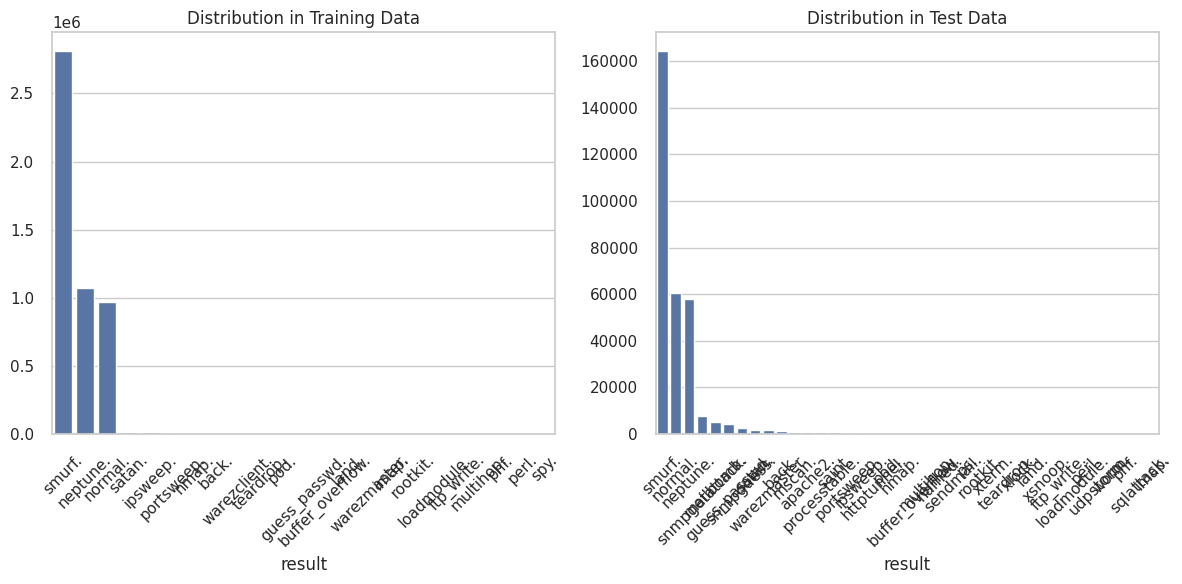

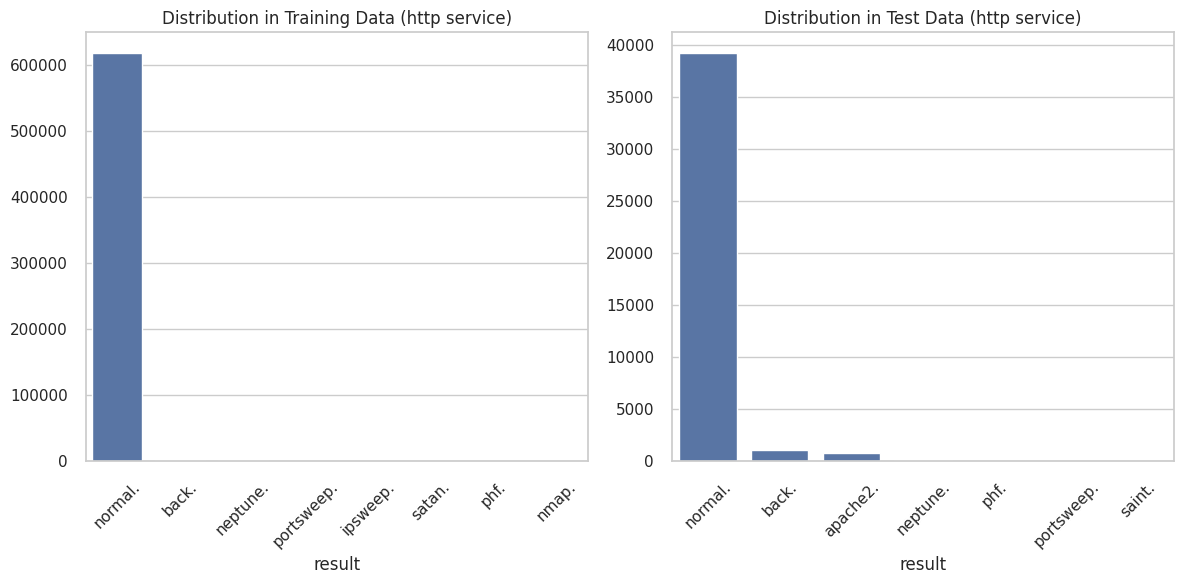

Training on 619046 normal samples
Test data distribution: {0: 39247, 1: 1990}
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=28, out_features=28, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=28, out_features=14, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=14, out_features=7, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
  )
  (mu_layer): Linear(in_features=7, out_features=3, bias=True)
  (logvar_layer): Linear(in_features=7, out_features=3, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=7, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=7, out_features=14, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=14, out_features=28, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=28, out_features=28

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [1/20], Loss: 23.1575, Recon Loss: 22.5411, KL Loss: 0.6164


Epoch 2/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [2/20], Loss: 22.2084, Recon Loss: 21.5570, KL Loss: 0.6514


Epoch 3/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [3/20], Loss: 21.6892, Recon Loss: 21.0110, KL Loss: 0.6782


Epoch 4/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [4/20], Loss: 21.4007, Recon Loss: 20.6812, KL Loss: 0.7195


Epoch 5/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [5/20], Loss: 21.2531, Recon Loss: 20.5402, KL Loss: 0.7129


Epoch 6/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [6/20], Loss: 21.1519, Recon Loss: 20.4144, KL Loss: 0.7375


Epoch 7/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [7/20], Loss: 21.0951, Recon Loss: 20.3389, KL Loss: 0.7562


Epoch 8/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [8/20], Loss: 21.0794, Recon Loss: 20.3256, KL Loss: 0.7539


Epoch 9/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [9/20], Loss: 21.0854, Recon Loss: 20.3193, KL Loss: 0.7661


Epoch 10/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [10/20], Loss: 21.1261, Recon Loss: 20.3611, KL Loss: 0.7650


Epoch 11/20:   0%|          | 0/4837 [00:00<?, ?it/s]

Epoch [11/20], Loss: 21.1226, Recon Loss: 20.3545, KL Loss: 0.7681
Early stopping triggered after 11 epochs.


<ipython-input-24-6f90e43f32ed>:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vae_model.pth'))


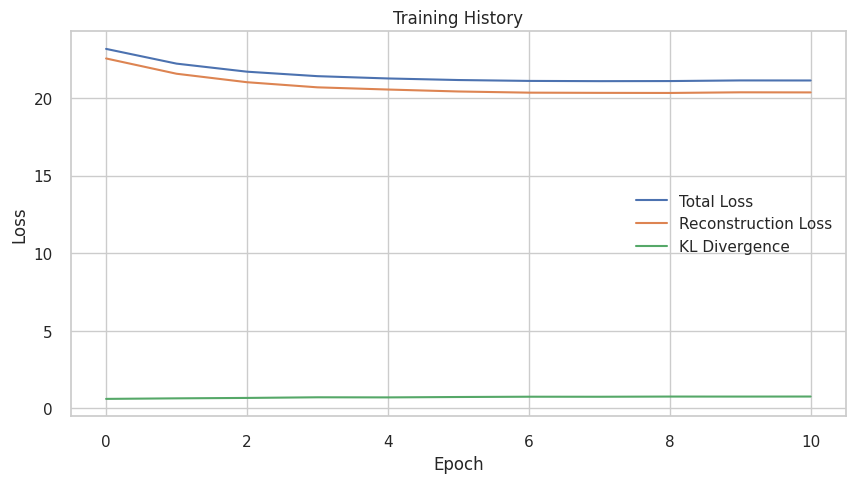

Optimal threshold: 0.004571 with F1: 0.9585


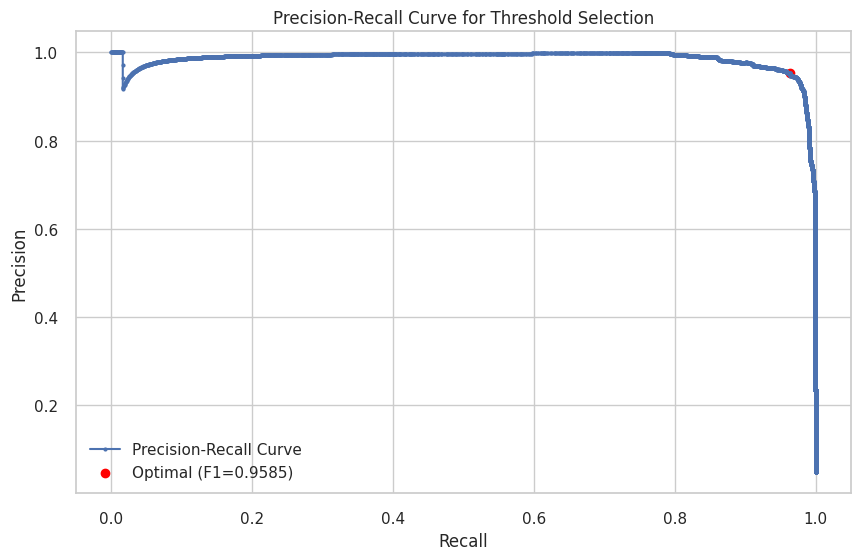

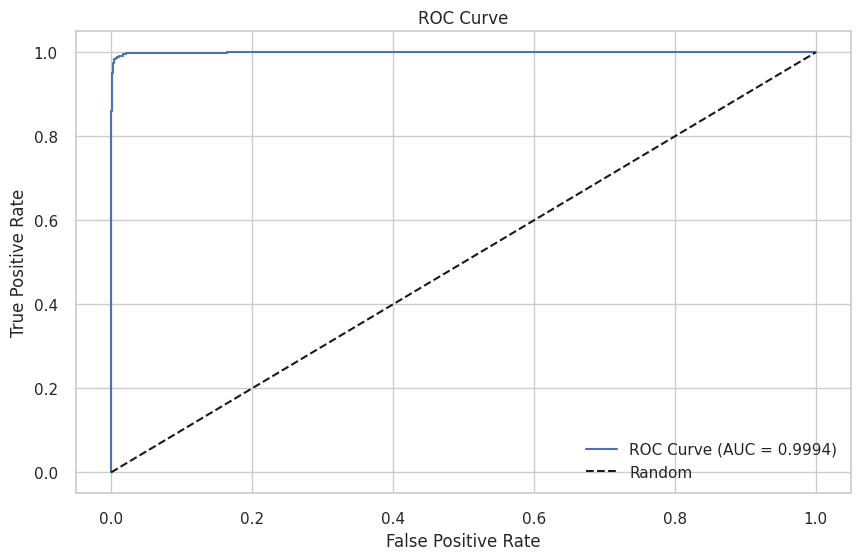


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39247
           1       0.95      0.96      0.96      1990

    accuracy                           1.00     41237
   macro avg       0.98      0.98      0.98     41237
weighted avg       1.00      1.00      1.00     41237



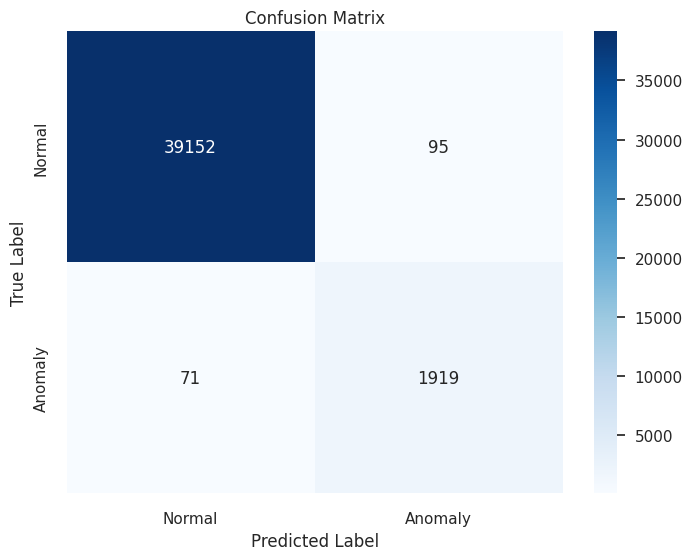


Summary Metrics:
Total samples: 41237
Total actual anomalies: 1990
Total predicted anomalies: 2014
Correctly identified anomalies: 1919
Missed anomalies: 71
False alarms: 95
Precision: 0.9528
Recall: 0.9643
F1 Score: 0.9585
False Discovery Rate (FDR): 0.0472
False Positive Rate (FPR): 0.0024
Specificity: 0.9976


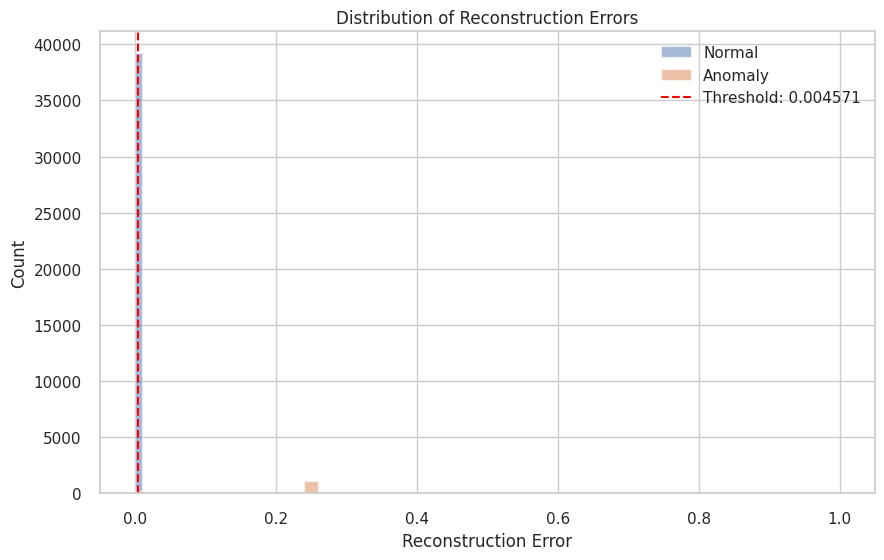

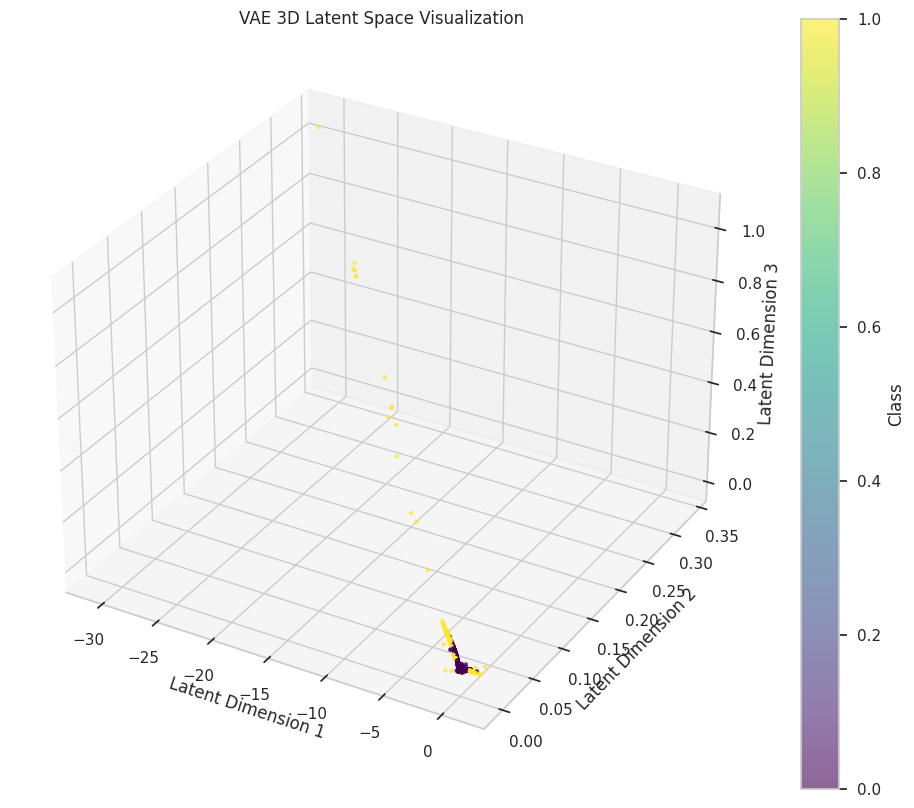

Network intrusion detection analysis complete!


In [ ]:
def main():
    """Main function to run the network intrusion detection."""
    # Load and preprocess data
    df_train, df_test, col_names = load_and_preprocess_data(config)

    # Explore data
    df_train_http, df_test_http = explore_data(df_train, df_test, config.SERVICE_TYPE)

    # Prepare data for model
    train_loader, X_train_tensor, X_test_tensor, y_test, input_dim = prepare_data_for_model(
        df_train_http, df_test_http, config
    )

    # Initialize model
    model = VAE(
        input_dim=input_dim,
        hidden_dims=config.HIDDEN_DIM,
        latent_dim=config.LATENT_DIM
    ).to(config.DEVICE)

    # Print model summary
    print(model)
    print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

    # Train model
    model, history = train_model(model, train_loader, config)

    # Compute reconstruction errors on training and test data
    train_recon_errors = compute_reconstruction_errors(model, X_train_tensor, config)
    test_recon_errors = compute_reconstruction_errors(model, X_test_tensor, config)

    # Find optimal threshold
    optimal_threshold = find_optimal_threshold(test_recon_errors, y_test)

    # Evaluate model
    metrics = evaluate_model(test_recon_errors, y_test, optimal_threshold)

    # Visualize latent space
    visualize_latent_space(model, X_test_tensor, y_test, config)

    print("Network intrusion detection analysis complete!")
    return model, metrics

# Execute main function
if __name__ == "__main__":
    model, metrics = main()

In [ ]:
from google.colab import runtime
runtime.unassign()